# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16814 entries, 0 to 16813
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sale_date                    16814 non-null  object
 1   sale_price                   16814 non-null  int64 
 2   house_square_feet            16814 non-null  int64 
 3   attic_finished_square_feet   16814 non-null  int64 
 4   basement_square_feet         16814 non-null  int64 
 5   attached_garage_square_feet  16814 non-null  int64 
 6   detached_garage_square_feet  16814 non-null  int64 
 7   fireplaces                   16814 non-null  int64 
 8   hvac_description             16807 non-null  object
 9   exterior                     16813 non-null  object
 10  interior                     16807 non-null  object
 11  stories                      16814 non-null  int64 
 12  roof_cover                   16806 non-null  object
 13  year_built                   16

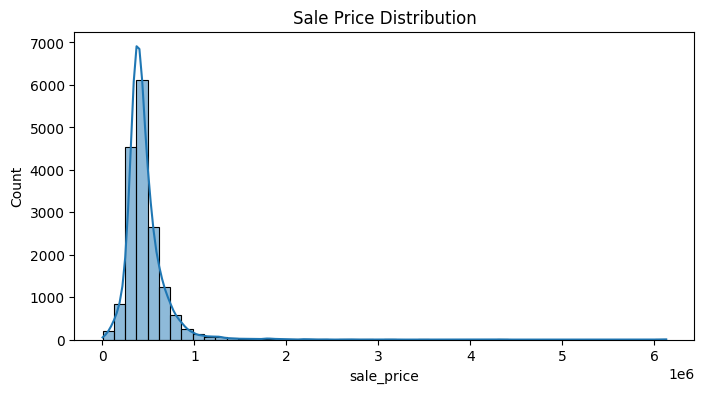

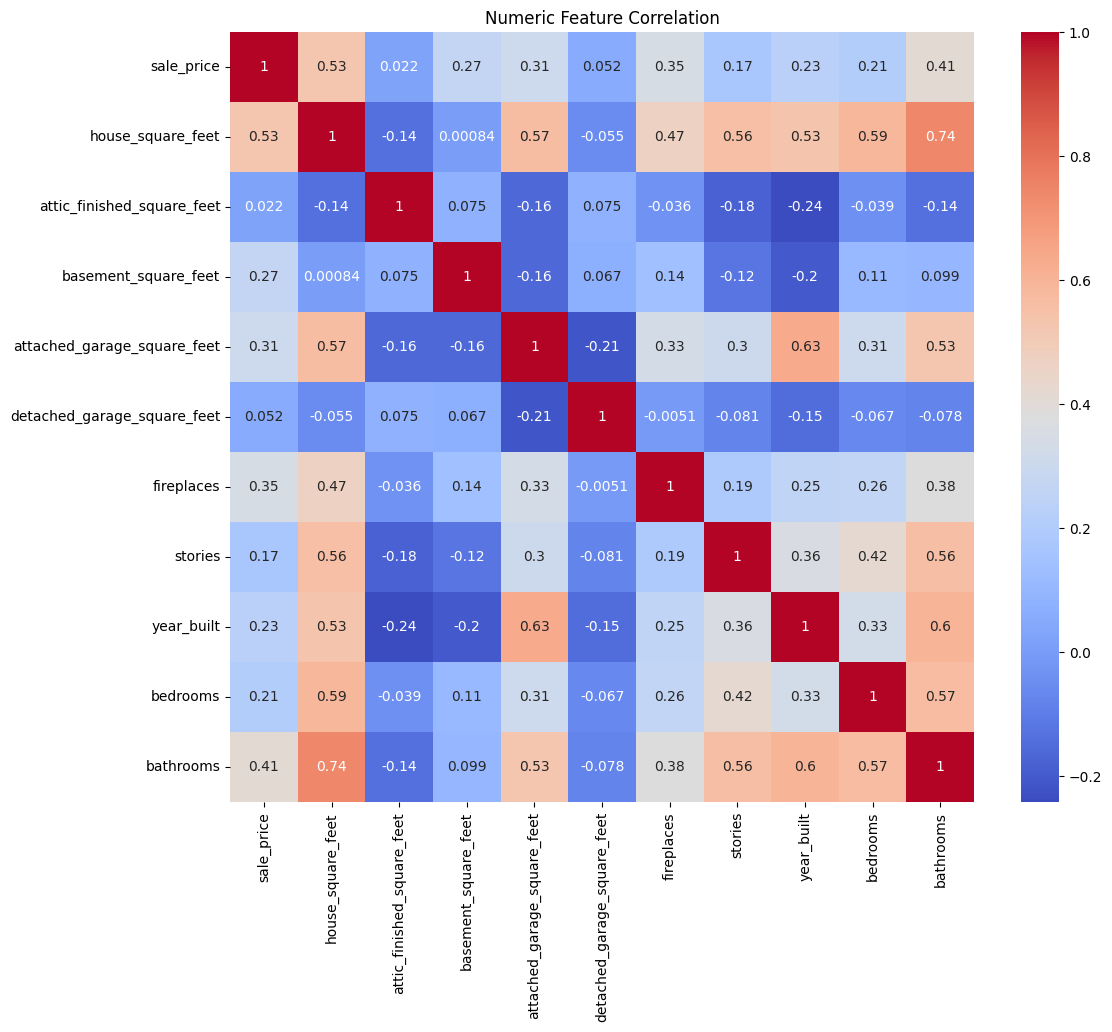

In [18]:
#1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./data/pierce_county_house_sales.csv")

# Initial look
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Drop columns with too many missing or irrelevant values
df = df.drop(columns=["waterfront_type", "view_quality"], errors='ignore')

# Convert dates
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Basic Visualization

# Plot price distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['sale_price'], bins=50, kde=True)
plt.title("Sale Price Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Numeric Feature Correlation")
plt.show()



In [19]:
#2
# One-hot encode categorical features
categorical_cols = ['hvac_description', 'exterior', 'interior', 'roof_cover', 'utility_sewer']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [20]:
#3
from sklearn.model_selection import train_test_split

X = df.drop(columns=["sale_price", "sale_date"])
y = df['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
#4
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_train_subset, X_test_subset, model_name):
    model.fit(X_train_subset, y_train)
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X_test_subset)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"--- {model_name} ---")
    print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
    print(f"Test RMSE:  {test_rmse:.2f}, R²: {test_r2:.4f}")
    print()

# Model 1: Just square footage
evaluate_model(LinearRegression(), 
               X_train[['house_square_feet']], 
               X_test[['house_square_feet']], 
               "Model 1: Square Footage Only")

# Model 2: Bedrooms and Bathrooms
evaluate_model(LinearRegression(), 
               X_train[['bedrooms', 'bathrooms']], 
               X_test[['bedrooms', 'bathrooms']], 
               "Model 2: Bedrooms + Bathrooms")

# Model 3: Square Footage + Year Built
evaluate_model(LinearRegression(), 
               X_train[['house_square_feet', 'year_built']], 
               X_test[['house_square_feet', 'year_built']], 
               "Model 3: Sqft + Year Built")

# Model 4: All features (baseline full model)
evaluate_model(LinearRegression(), 
               X_train, 
               X_test, 
               "Model 4: All Features")



--- Model 1: Square Footage Only ---
Train RMSE: 195447.67, R²: 0.2814
Test RMSE:  220635.05, R²: 0.2625

--- Model 2: Bedrooms + Bathrooms ---
Train RMSE: 209665.39, R²: 0.1731
Test RMSE:  236237.76, R²: 0.1545

--- Model 3: Sqft + Year Built ---
Train RMSE: 194856.44, R²: 0.2858
Test RMSE:  220271.09, R²: 0.2649

--- Model 4: All Features ---
Train RMSE: 173242.53, R²: 0.4354
Test RMSE:  200691.40, R²: 0.3898



Model 4 with all the features does the best.

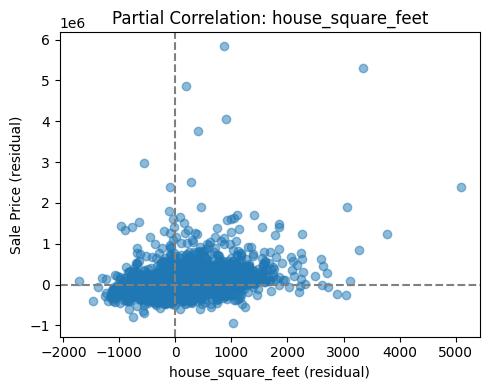

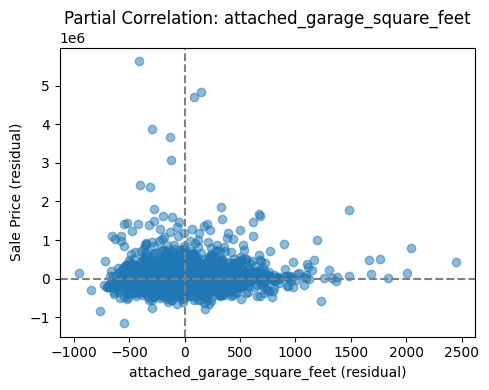

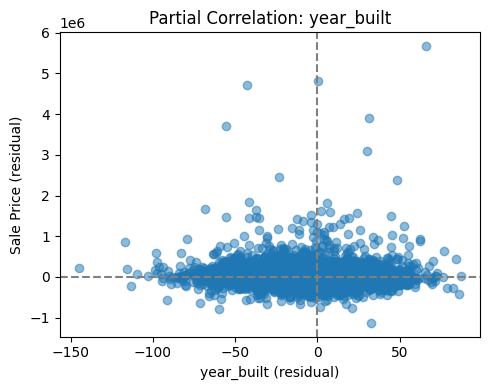

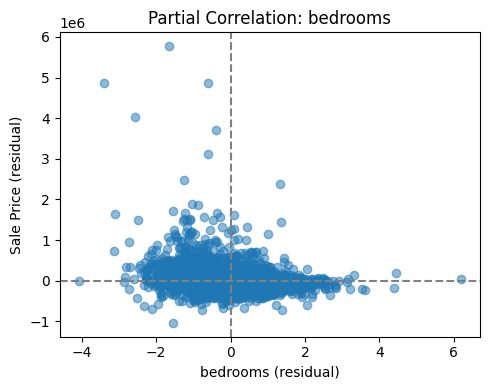

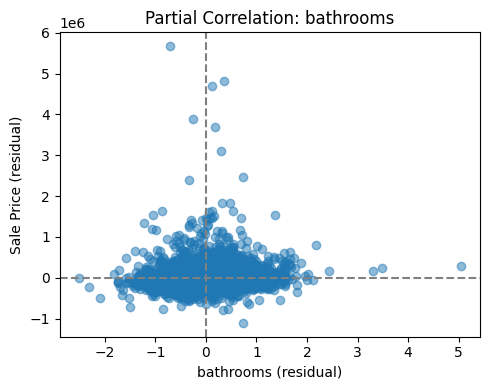

In [23]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Use only numeric columns
X_train_numeric = X_train.select_dtypes(include=[np.number])

def plot_partial_corr(var_name):
    other_vars = X_train_numeric.drop(columns=[var_name])

    # Regress y on other variables
    y_model = LinearRegression().fit(other_vars, y_train)
    y_resid = y_train - y_model.predict(other_vars)

    # Regress x on other variables
    x_model = LinearRegression().fit(other_vars, X_train_numeric[var_name])
    x_resid = X_train_numeric[var_name] - x_model.predict(other_vars)

    # Plot residuals
    plt.figure(figsize=(5, 4))
    plt.scatter(x_resid, y_resid, alpha=0.5)
    plt.title(f"Partial Correlation: {var_name}")
    plt.xlabel(f"{var_name} (residual)")
    plt.ylabel("Sale Price (residual)")
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

# Try a few key numeric features
for col in ['house_square_feet', 'attached_garage_square_feet', 'year_built', 'bedrooms', 'bathrooms']:
    if col in X_train_numeric.columns:
        plot_partial_corr(col)


Yes, there are noticeable non-linearities in some variables. For example, for house_square_feet, sale prices increase with size slightly, but the effect levels off. year_built has a slight upward curve. Bedrooms and attached_garage_square_fee show no clear trend, indicating weak or more complex effects. Bathrooms seem to have a parabolic shape.

In [24]:
#6
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Build a pipeline: Polynomial transformation + Linear Regression
poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

# Fit the model
poly_model.fit(X_train, y_train)

# Predict
y_train_poly = poly_model.predict(X_train)
y_test_poly = poly_model.predict(X_test)

# Evaluate
poly_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_poly))
poly_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_poly))
poly_train_r2 = r2_score(y_train, y_train_poly)
poly_test_r2 = r2_score(y_test, y_test_poly)

print(f"Train RMSE (Poly): {poly_train_rmse:.2f}, R²: {poly_train_r2:.4f}")
print(f"Test RMSE (Poly): {poly_test_rmse:.2f}, R²: {poly_test_r2:.4f}")



Train RMSE (Poly): 154262.56, R²: 0.5524
Test RMSE (Poly): 469819.61, R²: -2.3442


The polynomial model includes squared and interaction terms to capture non-linear relationships seen in 5. It fits the training data significantly better, as shown by a lower RMSE and higher R². While it performs better than simple linear models, the gap between training and test scores suggests some overfitting. Still, the improved test performance indicates it captures important patterns missed by simpler models.

In [25]:
#7

simple_train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
simple_test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
simple_train_r2 = r2_score(y_train, model.predict(X_train))
simple_test_r2 = r2_score(y_test, model.predict(X_test))

results = pd.DataFrame({
    'Model': ['Simple Linear (All Features)', 'Polynomial Regression (Degree 2)'],
    'Train RMSE': [simple_train_rmse, poly_train_rmse],
    'Test RMSE': [simple_test_rmse, poly_test_rmse],
    'Train R²': [simple_train_r2, poly_train_r2],
    'Test R²': [simple_test_r2, poly_test_r2]
})

print("Model Performance Comparison")
display(results)



Model Performance Comparison


,Model,Train RMSE,Test RMSE,Train R²,Test R²
0,Simple Linear (All Features),173242.529739,200691.396698,0.435441,0.389781
1,Polynomial Regression (Degree 2),154262.564767,469819.607559,0.552368,-2.344186


The results highlight key lessons about overfitting and model selection. The simple linear model had moderate performance with a Train R² of ~0.44 and Test R² of ~0.39. This suggests underfitting — the model is too simple to fully capture the complexity of housing prices. The polynomial model, on the other hand, had much better fit on the training set (R² = 0.55), but performed very poorly on the test set (R² = -2.34), with a much higher test RMSE. This is a clear sign of overfitting — the model learned patterns in the training data that didn’t generalize. This shows that increasing model complexity doesn't always improve real-world performance. It reinforces the importance of validating models on unseen data and using metrics like test RMSE and R² to guide model selection.

In [27]:
#8
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train Lasso with cross-validation to find best alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Predict
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)

# Evaluate
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_lasso))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_lasso))
lasso_train_r2 = r2_score(y_train, y_train_lasso)
lasso_test_r2 = r2_score(y_test, y_test_lasso)

n_selected = np.sum(lasso.coef_ != 0)

print("Lasso Regression Results:")
print(f"Lasso selected {n_selected} features (non-zero coefficients)")
print(f"Train RMSE: {lasso_train_rmse:.2f}, R²: {lasso_train_r2:.4f}")
print(f"Test RMSE: {lasso_test_rmse:.2f}, R²: {lasso_test_r2:.4f}")

selected_features = np.array(X_train.columns)[lasso.coef_ != 0]
print("Selected features by Lasso:")
print(selected_features)



Lasso Regression Results:
Lasso selected 6 features (non-zero coefficients)
Train RMSE: 182242.90, R²: 0.3753
Test RMSE: 208714.93, R²: 0.3400
Selected features by Lasso:
['house_square_feet' 'attic_finished_square_feet' 'basement_square_feet'
 'attached_garage_square_feet' 'detached_garage_square_feet' 'year_built']
